# Carla Lane Detection

Using Image Segmentation Models for Lane Detection on Carla Dataset

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import imageio
import cv2
import scipy
import albumentations as albu
import os
import random
import re

# PyTorch Libraries
!pip3 install segmentation-models-pytorch torchinfo
import torch as tr
from torch.utils.data import DataLoader, Dataset
from segmentation_models_pytorch.utils import base
from torchinfo import summary
import segmentation_models_pytorch as smp

     |████████████████████████████████| 87 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 376 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 5.9 MB/s  eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=c0f4600794eb05841b3d1e227d1b7181531c493bfe42b08e162445409e110a15
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=dbdce53f91e37e96f87fca261a2bcd74e2239f35efc5fc46e280e62316e5f033
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


## Segmentation Model

In [2]:
Model = smp.FPN(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    classes=3,
    activation='softmax2d'
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

## Data Preparation and Preprocessing

### Importing and Visualizing Data

Paths of Images and Masks

In [3]:
# Training Data

# Kaggle
Train_Images_Directories = "../input/lane-detection-for-carla-driving-simulator/train"
Train_Masks_Directories = "../input/lane-detection-for-carla-driving-simulator/train_label"

Valid_Images_Directories = "../input/lane-detection-for-carla-driving-simulator/val"
Valid_Masks_Directories = "../input/lane-detection-for-carla-driving-simulator/val_label"

### Augmentation and Preprocessing

Augmentation Function

In [4]:
def Create_Augmentation_Function():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)


Augmentations = Create_Augmentation_Function()

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


Preprocessing Function

In [5]:
Preprocess = smp.encoders.get_preprocessing_fn("efficientnet-b0", "imagenet")

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def Preprocessing(Preprocess_Function):   
    _transform = [
        albu.Lambda(image=Preprocess_Function),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

### Dataset and DataLoaders

Dataset

In [6]:
class CarlaLaneDetectionDataset(Dataset):
    def __init__(self, Images_Directory, Masks_Directory, num_classes, Augmentation, Preprocess):
        
        self.images = os.listdir(Images_Directory)
        self.Images_Path = [os.path.join(Images_Directory, image_id) for image_id in self.images]
        
        get_Mask = lambda fn: re.sub(".png", "_label.png", fn)
        self.Masks_Path = [os.path.join(Masks_Directory, get_Mask(image_id)) for image_id in self.images]
        
        self.num_classes = num_classes
        self.augmentation = Augmentation
        self.preprocessing = Preprocess
        
    def __getitem__(self, i):
        try:
            image = cv2.imread(self.Images_Path[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.Masks_Path[i], 0)    
        except:
            image = cv2.imread(self.Images_Path[i].decode("utf-8"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.Masks_Path[i].decode("utf-8"), 0)
            
        # Resizing
        image = cv2.resize(image, (512,256))
        mask = cv2.resize(mask, (512,256))
        
        if self.augmentation:
            # Applying Augmentations
            Augmented_Datapoint = self.augmentation(image=image, mask=mask)
            image, mask = Augmented_Datapoint['image'], Augmented_Datapoint['mask']
            
        if self.preprocessing:
            # Applying Preprocessing
            Preprocessed_Datapoint = self.preprocessing(image=image, mask=mask)
            image, mask = Preprocessed_Datapoint['image'], Preprocessed_Datapoint['mask']
        
        mask = np.eye(self.num_classes)[mask].transpose((2,0,1))
        
        return image, tr.LongTensor(mask)
    
    def __len__(self):
        return len(self.Images_Path)

DataLoader

In [7]:
Train_Dataset = CarlaLaneDetectionDataset(Train_Images_Directories, Train_Masks_Directories, 3, Augmentations, Preprocessing(Preprocess))
Valid_Dataset = CarlaLaneDetectionDataset(Valid_Images_Directories, Valid_Masks_Directories, 3, None, Preprocessing(Preprocess))

Visualizing Training Images and Masks after Augmentation and Preprocessing

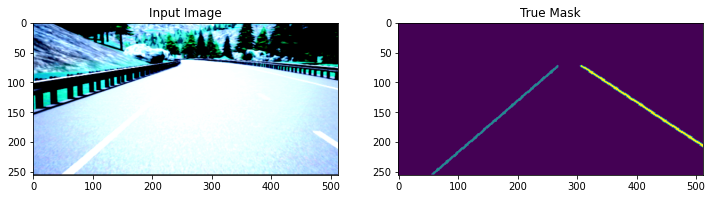

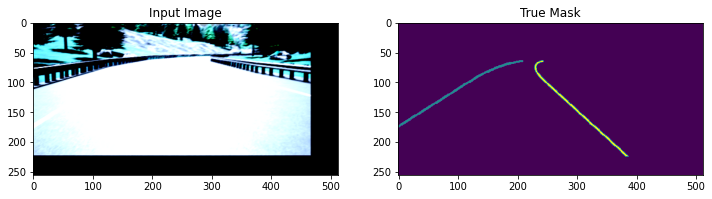

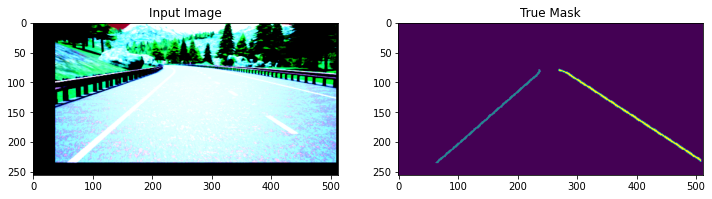

In [8]:
for i in range(3):
    image, mask = Train_Dataset[i]
    
    # Displaying Image
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(image.transpose(1,2,0))

    plt.subplot(1,2,2)
    plt.title("True Mask")
    plt.imshow(np.argmax(mask, axis=0))

    plt.show()

Visualizing Validation Images and Masks after Augmentation and Preprocessing

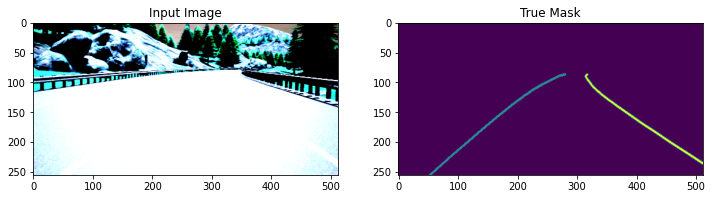

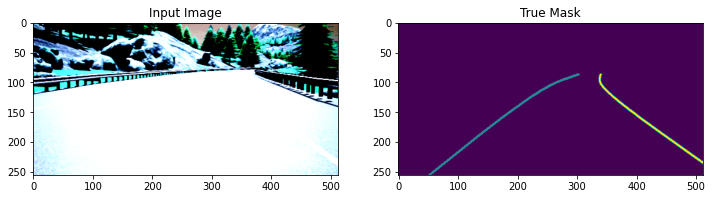

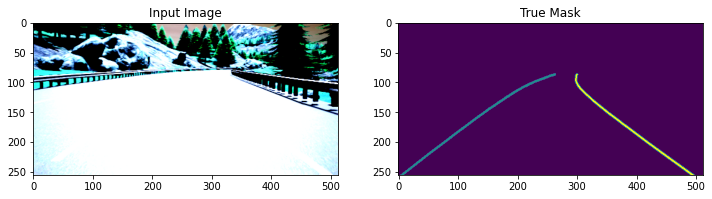

In [9]:
for i in range(3):
    image, mask = Valid_Dataset[i]
    
    # Displaying Image
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(image.transpose(1,2,0))

    plt.subplot(1,2,2)
    plt.title("True Mask")
    plt.imshow(np.argmax(mask,axis=0))

    plt.show()

## Training Lane Detection Model

Training Parameters

In [10]:
Batch_Size = 8
Epochs = 10

DataLoaders

In [11]:
Train_DataLoader = DataLoader(Train_Dataset, batch_size=Batch_Size, shuffle=True)
Valid_DataLoader = DataLoader(Valid_Dataset, batch_size=Batch_Size, shuffle=True)

Training Settings

In [12]:
optimizer = tr.optim.Adam(Model.parameters(), lr=0.0001)

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = smp.utils.losses.DiceLoss()
        self.BinaryDiceLossRight = smp.utils.losses.DiceLoss()
        
    def forward(self, y_pr, y_gt):
        y_gt = tr.argmax(y_gt, axis=1)
        left_gt = (y_gt == 1)
        right_gt = (y_gt == 2)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,1,:,:] , left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:,2,:,:] , right_gt)
        return (loss_left + loss_right)*0.5
    
Loss = MultiDiceLoss()

IoU = smp.utils.metrics.IoU()

Training and Validation Epochs

In [13]:
train_epoch = smp.utils.train.TrainEpoch(
    Model,
    loss=Loss,
    metrics=[IoU],
    optimizer=optimizer,
    device="cuda",
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    Model, 
    loss=Loss, 
    metrics=[IoU],
    device="cuda",
    verbose=True
)

Training the Model

In [14]:
for epoch in range(Epochs):
    print ("Epoch-" + str(epoch) + ":")
    train_epoch.run(Train_DataLoader)
    valid_epoch.run(Valid_DataLoader)

Epoch-0:
valid: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s, multi_dice_loss - 0.343, iou_score - 0.9804] 
Epoch-1:
valid: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s, multi_dice_loss - 0.2772, iou_score - 0.9846]
Epoch-2:
valid: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s, multi_dice_loss - 0.2524, iou_score - 0.9859]
Epoch-3:
valid: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s, multi_dice_loss - 0.2343, iou_score - 0.9871]
Epoch-4:
valid: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s, multi_dice_loss - 0.2208, iou_score - 0.9882]
Epoch-5:
valid: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s, multi_dice_loss - 0.2063, iou_score - 0.9889]
Epoch-6:
valid: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s, multi_dice_loss - 0.2023, iou_score - 0.9889]
Epoch-7:
valid: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s, multi_dice_loss - 0.2173, iou_score - 0.9878]
Epoch-8:
valid: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s, multi_dice_loss - 0.2031, iou_score - 0.9886]
Epoch-9:
v

Saving Model

In [15]:
tr.save(Model, "LaneDetection_Model.pth")

## Evaluate Model

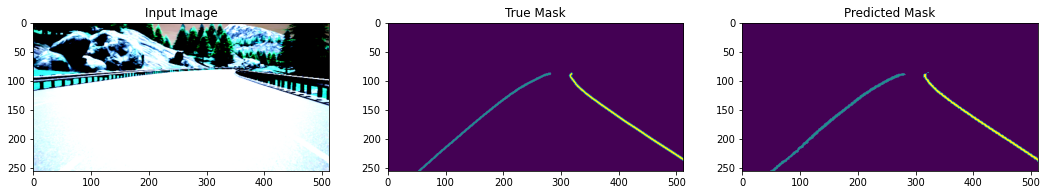

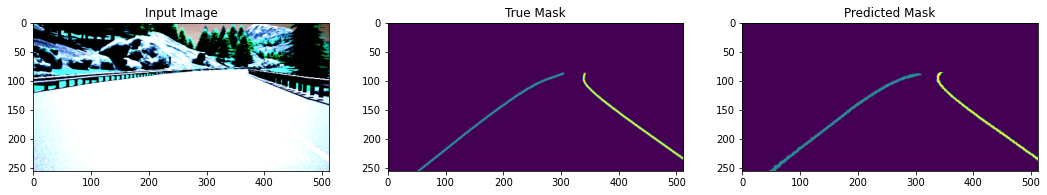

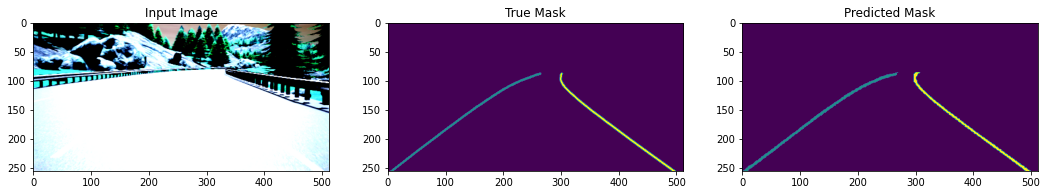

In [16]:
for i in range(3):
    image, mask = Valid_Dataset[i]
    
    # Predicting
    X = tr.from_numpy(np.expand_dims(image, axis=0)).to("cuda")
    pred = Model.predict(X).cpu().numpy()[0]
    
    # Displaying Image
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(image.transpose(1,2,0))

    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(np.argmax(mask, axis=0))
    
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(pred, axis=0))

    plt.show()